### Import Dependencies

In [1]:
from pydantic import BaseModel, Field

from qdrant_client import QdrantClient
from qdrant_client.models import Prefetch, FusionQuery, Document

from langsmith import traceable

from langgraph.graph import StateGraph, START, END
from langgraph.types import Send

from jinja2 import Template
from typing import Annotated, List, Any
from IPython.display import Image, display
from operator import add
from openai import OpenAI

import openai
import instructor

from utils.utils import get_tool_descriptions, format_ai_message
from dotenv import load_dotenv, find_dotenv

/Users/datapsycho/PythonProjects/EtoEAIBoocamp/aieng-bootcamp-defaut/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv(find_dotenv(), override=True)

True

In [3]:
class State(BaseModel):
    expanded_query: List[str] = []
    retrieved_context: Annotated[List[str], add] = []
    question_relevant: bool = False
    initial_query: str = ""
    answer: str = ""
    query: str = ""
    k: int = 10

In [4]:
class QueryExpandResponse(BaseModel):
    expanded_query: List[str]

In [5]:
@traceable(
    name="agent_node",
    run_type="llm",
    metadata={"ls_provider": "openai", "ls_model_name": "gpt-4.1-mini"}
)
def query_expand_node(state: State):

   prompt_template =  """You are part of a shopping assistant that can answer questions about products in stock.

Instructions:
- You will be given a question and you need to expand it into a list statements that can be used in contextual search to retrieve relevant products.
- The statements should not overlap in context. Single item should not be expanded into multiple statements unless it is specifically mentioned in several contexts.

<Question>
{{ query }}
</Question>
"""

   template = Template(prompt_template)
   
   prompt = template.render(
      query=state.initial_query
   )

   client = instructor.from_openai(OpenAI())

   response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        response_model=QueryExpandResponse,
        messages=[{"role": "system", "content": prompt}],
        temperature=0.5,
   )

   return {
      "expanded_query": response.expanded_query
      }

In [6]:
def query_expand_conditional_edges(state: State):

    send_messages = []

    for query in state.expanded_query:
        send_messages.append(
            Send(
                "retrieve_node",
                {
                    "query": query,
                    "k": 10
                }
            )
        )

    return send_messages

In [7]:
@traceable(
    name="embed_query",
    run_type="embedding",
    metadata={"ls_provider": "openai", "ls_model_name": "text-embedding-3-small"}
)
def get_embedding(text, model="text-embedding-3-small"):
    response = openai.embeddings.create(
        input=[text],
        model=model,
    )

    return response.data[0].embedding

@traceable(
    name="retrieve_top_n",
    run_type="retriever"
)
def retrieve_node(state: State) -> dict:

    qdrant_client = QdrantClient(url="http://localhost:6333")

    query_embedding = get_embedding(state["query"])

    results = qdrant_client.query_points(
        collection_name="Amazon-items-collection-01-hybrid-search",
        prefetch=[
            Prefetch(
                query=query_embedding,
                using="text-embedding-3-small",
                limit=20
            ),
            Prefetch(
                query=Document(
                    text=state["query"],
                    model="qdrant/bm25"
                ),
                using="bm25",
                limit=20
            )
        ],
        query=FusionQuery(fusion="rrf"),
        limit=state["k"],
    )

    retrieved_context = []
    retrieved_context_ids = [] 
    retrieved_context_ratings = []

    for result in results.points:
        retrieved_context_ids.append(result.payload["parent_asin"])
        retrieved_context.append(result.payload["description"])
        retrieved_context_ratings.append(result.payload["average_rating"])

    formatted_context = ""

    for id, chunk, rating in zip(retrieved_context_ids, retrieved_context, retrieved_context_ratings):
        formatted_context += f"- ID: {id}, rating: {rating}, description: {chunk}\n"

    return {
        "retrieved_context": [formatted_context],
    }

In [8]:
class AggregatorResponse(BaseModel):
    answer: str = Field(description="Answer to the question.")

In [9]:
@traceable(
    name="agent_node",
    run_type="llm",
    metadata={"ls_provider": "openai", "ls_model_name": "gpt-4.1-mini"}
)
def aggregator_node(state: State) -> dict:

   preprocessed_context = "\n".join(state.retrieved_context)

   prompt_template =  """You are a shopping assistant that can answer questions about the products in stock.

You will be given a question and a list of context.

Instructions:
- You need to answer the question based on the provided context only.
- Never use word context and refer to it as the available products.
- The answer to the question should contain detailed information about the product and returned with detailed specification in bullet points.

Context:
{{ preprocessed_context }}

Question:
{{ question }}
"""

   template = Template(prompt_template)
   
   prompt = template.render(
      preprocessed_context=preprocessed_context,
      question=state.initial_query
   )

   client = instructor.from_openai(OpenAI())

   response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        response_model=AggregatorResponse,
        messages=[{"role": "system", "content": prompt}],
        temperature=0.5,
   )

   return {
      "answer": response.answer
   }

### User Intent Router Node

In [10]:
class IntentRouterResponse(BaseModel):
    question_relevant: bool
    answer: str

In [11]:
@traceable(
    name="agent_node",
    run_type="llm",
    metadata={"ls_provider": "openai", "ls_model_name": "gpt-4.1-mini"}
)
def intent_router_node(state: State):

   prompt_template =  """You are part of a shopping assistant that can answer questions about products in stock.

Instructions:
- You will be given a question and you need to clasify it into relevant or not relevant.
- If the question is not relevant, return False in field "question_relevant" and set "answer" to explanation why it is not relevant.
- If the question is relevant, return True in field "question_relevant" and set "answer" to "".
- You should only answer questions about the products in stock. If the question is not about the products in stock, you should ask for clarification.

<Question>
{{ query }}
</Question>
"""

   template = Template(prompt_template)
   
   prompt = template.render(
      query=state.initial_query
   )

   client = instructor.from_openai(OpenAI())

   response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        response_model=IntentRouterResponse,
        messages=[{"role": "system", "content": prompt}],
        temperature=0.5,
   )

   return {
      "question_relevant": response.question_relevant,
      "answer": response.answer
      }

In [12]:
def intent_router_conditional_edges(state: State):

    if state.question_relevant:
        return "query_expand_node"
    else:
        return "end"


In [13]:
workflow = StateGraph(State)

workflow.add_node("query_expand_node", query_expand_node)
workflow.add_node("retrieve_node", retrieve_node)
workflow.add_node("aggregator_node", aggregator_node)
workflow.add_node("intent_router_node", intent_router_node)

workflow.add_edge(START, "intent_router_node")
workflow.add_conditional_edges(
    "intent_router_node",
    intent_router_conditional_edges,
    {
        "query_expand_node": "query_expand_node",
        "end": END
    }
)
workflow.add_conditional_edges("query_expand_node", query_expand_conditional_edges)

workflow.add_edge("retrieve_node", "aggregator_node")
workflow.add_edge("aggregator_node", END)

graph = workflow.compile()

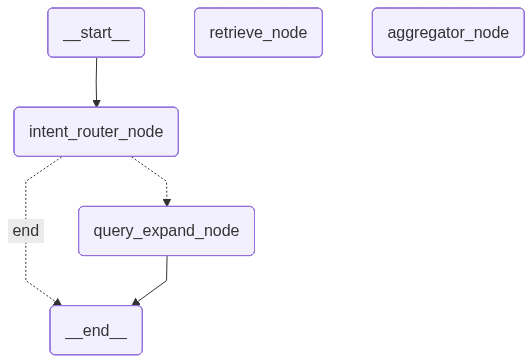

In [14]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
initial_state = {
    "initial_query": "Can I get a tablet for my kid, a watch for me a laptop for my wife and a waterproof speaker for our party next week?"
}
result = graph.invoke(initial_state)

Fetching 18 files: 100%|██████████| 18/18 [00:00<00:00, 2775.64it/s]


In [16]:
result

{'expanded_query': ['tablet for kids',
  'watch for adults',
  'laptop for wife',
  'waterproof speaker for party'],
 'retrieved_context': ['- ID: B0C3XYD574, rating: 4.4, description: ROWT Tablet for Kids 10 inch Kids Tablet 2GB RAM 32GB ROM Android 11 6000mAh Wi-Fi, Bluetooth, Kid-Proof Case(Blue) 【Kids\' Safety & Parental Controls】Looking for a safe tablet that\'s easy for your kids to use? This 10-inch tablet for kids is GMS-certified, has password protection, a content filter, and a one-button lock screen, making it easier for parents to keep an eye on their kids activities and learning. 【Creative Educational Content】Our kids tablet provides access to a range of age-appropriate creative kids content such as drawing, educational games, eBooks, learning videos, math tools, and much more! Learning through play is best for kids to understand the world. 【Powerful Configuration & Full Access to Google】This Android 11 kids tablet has an HD 1280x800 IPS touchscreen, 1.6 GHz Quad-Core proc

In [17]:
print(result["answer"])

Yes, you can get all those items from the available products:

1. Tablet for your kid:
- ROWT Tablet for Kids 10 inch
  - 10.1-inch HD 1280x800 IPS touchscreen
  - Android 11 OS
  - 2GB RAM, 32GB ROM storage
  - 6000mAh battery
  - Kid-proof case with built-in stand
  - GMS-certified with parental controls and content filter
  - Access to Google Play for apps like Gmail, Disney+, YouTube
  - Dual cameras
  - Eye protection with reduced blue light

2. Watch for you:
- Blackview R5 Smart Watch
  - 24 sports modes
  - Heart rate monitor, blood oxygen SpO2
  - IP68 waterproof
  - Sleep tracker
  - Long battery life (9-15 days)
  - Compatible with iOS 9.0+ and Android 4.3+

3. Laptop for your wife:
- Acer Aspire 5 A515-56-347N Slim Laptop
  - 15.6" Full HD IPS display
  - 11th Gen Intel i3-1115G4 Dual Core processor
  - 8GB DDR4 RAM
  - 128GB NVMe SSD
  - WiFi 6, Bluetooth, HDMI
  - Windows 11 Home in S Mode

4. Waterproof speaker for your party:
- ZEALOT Bluetooth Speakers
  - 80W output w

In [18]:
initial_state = {
    "initial_query": "Whats the weather today?"
}
result = graph.invoke(initial_state)

In [19]:
result

{'retrieved_context': [],
 'question_relevant': False,
 'initial_query': 'Whats the weather today?',
 'answer': 'The question is not relevant because it asks about the weather today, which is unrelated to the products in stock.'}